In [1]:
import wrangle as w
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = w.get_cws_data()

In [3]:
df

,id,total_charges,amount_paid,open,charge_code,description,prop_id,charge_name,sStatus,rent,term,monthly_inc,GuarantorRequired,total_inc,Recommendation,age,risk_score,reason,bad_resident
0,3946,75.00,75.00,0,131,"Uncllctbl key, remote fees",136,"Uncllctbl key, remote fees",Current,1311,15,52500,False,666000,Accept,33,745,Insufficient period of Residence History,1
1,3962,13.66,13.66,0,112,Water 8/1/2021-9/1/2021,136,Utility-water charges,Current,1661,12,65000,False,889992,Accept with Conditions (Extra Deposit),27,758,No Credit Experience,0
2,4050,46.17,46.17,0,155,Damage charges - Clean,136,Damage charges,Current,1412,12,48000,False,576000,Accept with Conditions (Extra Deposit),33,666,Insufficient period of Residence History,1
3,4948,9.76,9.76,0,111,Sewer Charge,140,Utility-sewer charges,Current,1377,18,72000,False,0,A-Criminal History Meets Requirements,39,0,Meets All Property Requirements,0
4,5001,6.85,6.85,0,113,Sewer Base Charge,140,Utility-water flat base charges,Current,2199,13,0,True,54996,Accept with Conditions (Guarantor),23,752,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,74033,1439.37,1439.37,0,74,Rent for 29 days,85,Rent,Current,1489,12,0,True,0,Accept with Conditions (Guarantor),24,708,Insufficient Income to Support Rent,0
4995,74056,150.00,150.00,0,162,Deposit Waiver Fee (Amount subject to screenin...,152,Deposit waiver fee,Current,1859,13,10000,False,121776,Accept,32,786,Meets All Property Requirements,0
4996,74230,5.00,5.00,0,186,Convenience Fee,61,OSP resident convenience fee,Current,1439,12,4350,False,57432,Accept with Conditions (Extra Deposit),36,691,Limited period of Residence History,0
4997,74231,5.00,5.00,0,186,Convenience Fee (ray farmer),83,OSP resident convenience fee,Current,1739,12,7916,False,94992,Accept,47,770,Meets All Property Requirements,0


In [4]:
train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test = w.train_vailidate_test_split(df, 'bad_resident', 'bad_resident')

In [5]:
# Finding the average risk score for residents
train.risk_score.mean()

592.5909253304752

(array([412.,   0.,   0.,   0.,   1.,  38., 212., 590., 904., 642.]),
 array([  0. ,  83.6, 167.2, 250.8, 334.4, 418. , 501.6, 585.2, 668.8,
        752.4, 836. ]),
 <BarContainer object of 10 artists>)

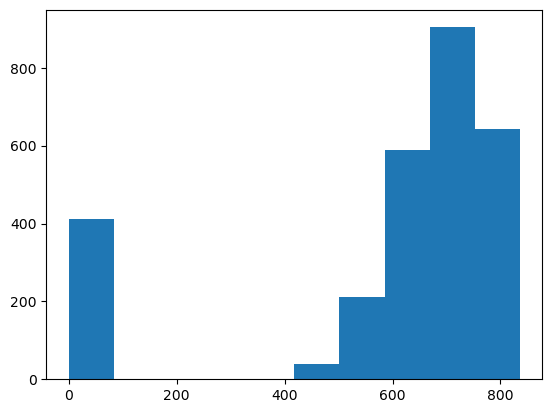

In [6]:
plt.hist(train.risk_score)

In [7]:
# Creating custom bins with 100 range and binning both total train pop and only bad train pop
bins = [300,400,500,600,700,800,900]
risk_bin = pd.cut(train['risk_score'], bins = bins)
bad_risk = pd.cut(train[train.bad_resident == 1].risk_score, bins = bins)

<AxesSubplot:xlabel='risk_score', ylabel='count'>

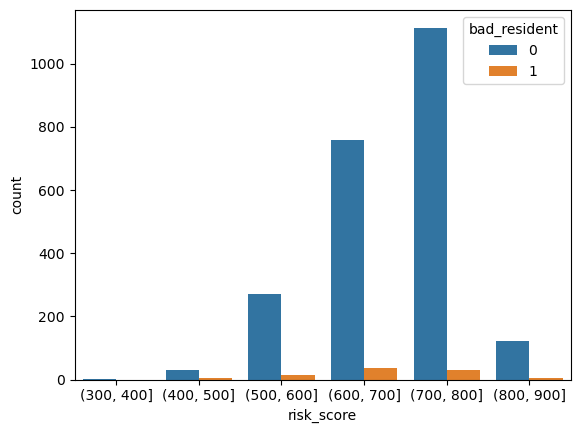

In [8]:
# Residents by risk score and hued by who is a bad resident
sns.countplot(x = risk_bin, hue = train.bad_resident)

In [81]:
bins = [300,400,500,600,700,800,900]
r1 = len(train[(train.risk_score < 301) & (train.bad_resident == 1)]) / len(train.risk_score[train.risk_score < 301])
r2 = len(train[(train.risk_score >300) & (train.risk_score < 401) & (train.bad_resident == 1)]) / len(train[(train.risk_score >300) & (train.risk_score < 401)])
r3 = (len(train[(train.risk_score >400) & (train.risk_score < 501) & (train.bad_resident == 1)]) / 
len(train[(train.risk_score >400) & (train.risk_score < 501)]))
r4 = (len(train[(train.risk_score >500) & (train.risk_score < 601) & (train.bad_resident == 1)]) / 
len(train[(train.risk_score >500) & (train.risk_score < 601)]))
r5 = (len(train[(train.risk_score >600) & (train.risk_score < 701) & (train.bad_resident == 1)]) / 
len(train[(train.risk_score >600) & (train.risk_score < 701)]))
r6= (len(train[(train.risk_score >700) & (train.risk_score < 801) & (train.bad_resident == 1)]) / 
len(train[(train.risk_score >700) & (train.risk_score < 801)]))
r7 = (len(train[(train.risk_score >800) & (train.risk_score < 100000000) & (train.bad_resident == 1)]) / 
len(train[(train.risk_score >800) & (train.risk_score < 100000000)]))

In [83]:
rs = pd.DataFrame(data = {'0-300': r1, '300-400': r2, '400-500': r3, '500-600': r4,
                         '600-700': r5, '700-800': r6, '>800':r7}, index = [0])

In [86]:
rs = rs.T.sort_values(0).T

In [88]:
rs = rs.round(2) * 100

<AxesSubplot:>

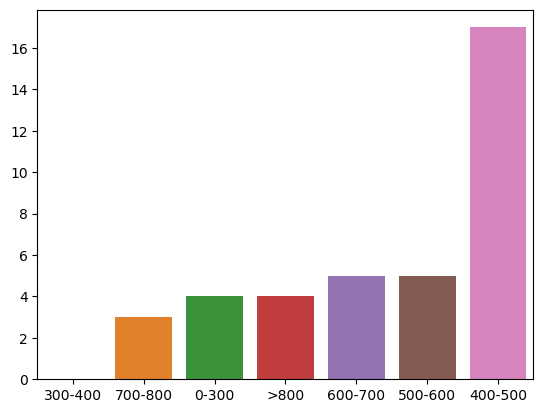

In [89]:
sns.barplot(data = rs)

<AxesSubplot:xlabel='risk_score', ylabel='count'>

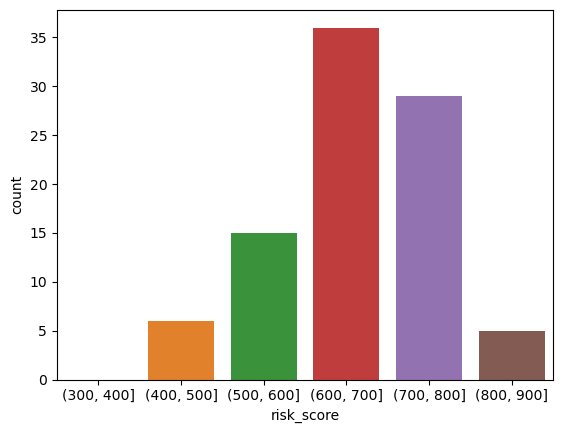

In [60]:
# Plotting only bad residents by risk score
sns.countplot(x = bad_risk)

In [10]:
# Setting the risk scores by bad_res in prep for t test
# Null hypothesis is risk score isnt different
risk_yes = train[train.bad_resident == 1].risk_score
risk_no = train[train.bad_resident == 0].risk_score

In [11]:
# Checking variance
print(risk_no.var(), risk_yes.var())

66005.06669802975 63724.151119731985


In [12]:
# Running ind t-test
t, p = stats.ttest_ind(risk_yes, risk_no, equal_var=False)
t, p / 2

(-1.0806422746527118, 0.14105963860511503)

In [13]:
# Creating a crosstab of risk bins and bad resident
observed = pd.crosstab(train.bad_resident, risk_bin)
observed

risk_score,"(300, 400]","(400, 500]","(500, 600]","(600, 700]","(700, 800]","(800, 900]"
bad_resident,,,,,,
0,1,30,271,758,1114,122
1,0,6,15,36,29,5


In [14]:
print(7/(7+25), 18/(282+18), 31/(31+744), 28/(1133+28), 2/114)

0.21875 0.06 0.04 0.024117140396210164 0.017543859649122806


In [15]:
# running a chi2 test on the observed crosstab
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(24.062866985556475, 0.00021115584204228419)

## Risk Score is statistically siginificant to bad residents

In [16]:
train.loc[2376]

id                                                       62552
total_charges                                             2.13
amount_paid                                               2.13
open                                                         0
charge_code                                                180
description          Administration Processing Fee for 16 days
prop_id                                                    112
charge_name                      Administration processing fee
sStatus                                                Current
rent                                                      2489
term                                                         6
monthly_inc                                            1500000
GuarantorRequired                                        False
total_inc                                                    0
Recommendation                            A-Meets Requirements
age                                                    

In [17]:
#Finding mean monthly income
train.monthly_inc.mean()

10454.414790996785

In [18]:
# Finding monthly incomes greater than top 1% US earners
len(train[train.monthly_inc <= 20000]) - len(train)

-153

In [19]:
# Turning assumed yearly incomes into monthly incomes
train.monthly_inc = np.where(train.monthly_inc >= 20000, train.monthly_inc/12, train.monthly_inc)

In [20]:
# Sorting new values
train.monthly_inc.sort_values(ascending = False).head(50)

2376    125000.000000
777      83333.333333
1665     29166.000000
1546     20833.333333
959      19166.000000
2482     18500.000000
2286     18000.000000
3609     17833.000000
796      17637.000000
3710     17600.000000
4294     17500.000000
250      17472.000000
4786     17220.000000
2281     17166.000000
413      17000.000000
3788     17000.000000
1094     17000.000000
1279     17000.000000
1192     16800.000000
3920     16667.000000
758      16667.000000
4574     16667.000000
291      16667.000000
2926     16666.000000
4909     16500.000000
1889     16333.000000
3736     16250.000000
3774     15995.000000
877      15909.000000
4913     15833.000000
2857     15833.000000
2911     15800.000000
1143     15750.000000
407      15667.000000
1568     15500.000000
2696     15000.000000
4411     15000.000000
4707     15000.000000
4415     15000.000000
627      15000.000000
956      15000.000000
4801     15000.000000
4743     15000.000000
1424     15000.000000
4662     15000.000000
4470     1

In [21]:
train.loc[2376]

id                                                       62552
total_charges                                             2.13
amount_paid                                               2.13
open                                                         0
charge_code                                                180
description          Administration Processing Fee for 16 days
prop_id                                                    112
charge_name                      Administration processing fee
sStatus                                                Current
rent                                                      2489
term                                                         6
monthly_inc                                           125000.0
GuarantorRequired                                        False
total_inc                                                    0
Recommendation                            A-Meets Requirements
age                                                    

In [22]:
# Replacing any blank total income with monthly income * 12
train.total_inc = np.where(train.total_inc == 0, train.monthly_inc * 12, train.total_inc)

In [23]:
# Replacing any blank monthly income with total income / 12
train.monthly_inc = np.where(train.monthly_inc == 0, train.total_inc/12, train.monthly_inc)

In [24]:
# Finding the mean yearly income
train.total_inc.mean()

114228.31332618793

In [25]:
# New monthly mean after adjustments
train.monthly_inc.mean()

6084.5061926878625

(0.0, 20000.0)

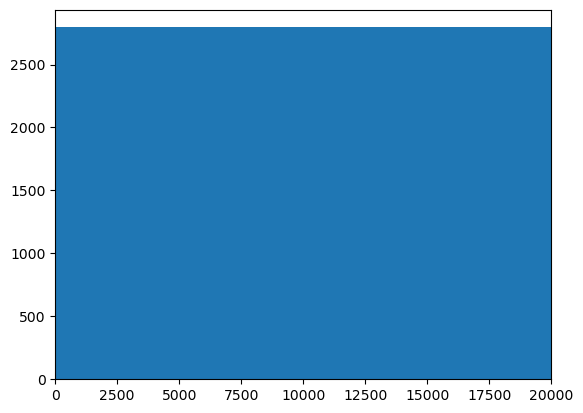

In [26]:
plt.hist(train.monthly_inc)
plt.xlim([0,20000])

(0.0, 20000.0)

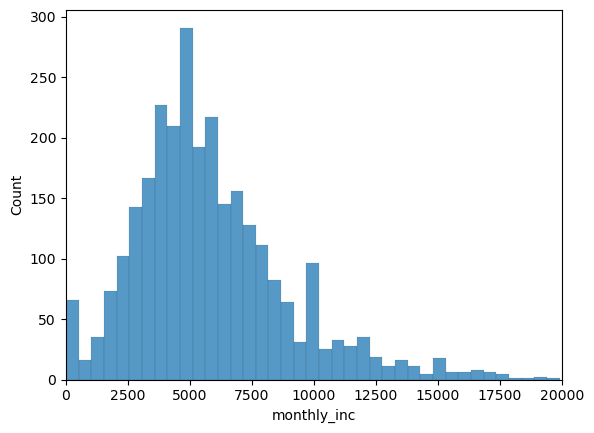

In [27]:
#plotting monthly income
sns.histplot(train.monthly_inc)
plt.xlim([0, 20000])

(0.0, 1000000.0)

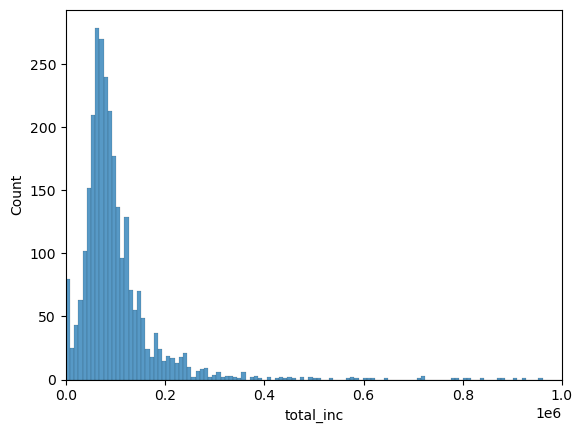

In [28]:
# Plotting yearly income
sns.histplot(train.total_inc)
plt.xlim([0, 1000000])

In [29]:
# Creating the variables for a t test
risk_yes = train[train.bad_resident == 1].monthly_inc
risk_no = train[train.bad_resident == 0].monthly_inc

In [30]:
# Checking variance
print(risk_yes.var(), risk_no.var())

806669229.4537473 18158725.28192593


In [31]:
# Running ind t-test
t, p = stats.ttest_ind(risk_yes, risk_no, equal_var=False)
t, p / 2

(0.8157190453377576, 0.20824339658791008)

In [32]:
# ttest variables
risk_yes = train[train.bad_resident == 1].total_inc
risk_no = train[train.bad_resident == 0].total_inc

In [33]:
# Checking variance
print(risk_yes.var(), risk_no.var())

120628546403.1007 30849709535.838337


In [34]:
# Running ind t-test
t, p = stats.ttest_ind(risk_yes, risk_no, equal_var=False)
t, p / 2

(0.44083480738401, 0.330106211022125)

In [35]:
inc_bins = [0, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 10000000]
month = pd.qcut(train.monthly_inc, 4)

<AxesSubplot:xlabel='monthly_inc', ylabel='count'>

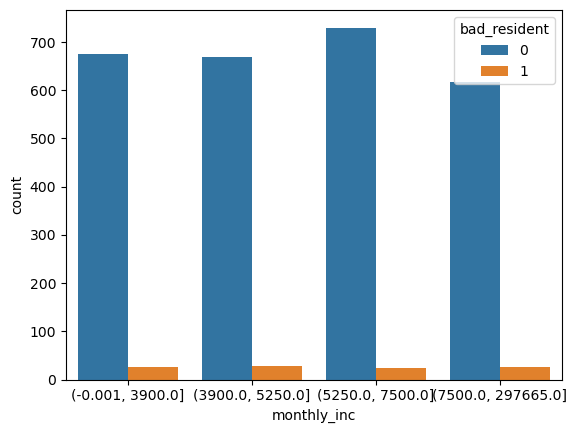

In [36]:
sns.countplot(x = month, hue = train.bad_resident)

In [37]:
# Creating a crosstab of risk bins and bad resident
observed = pd.crosstab(train.bad_resident, month)
observed

monthly_inc,"(-0.001, 3900.0]","(3900.0, 5250.0]","(5250.0, 7500.0]","(7500.0, 297665.0]"
bad_resident,,,,
0,676,668,730,618
1,27,29,24,27


In [38]:
# running a chi2 test on the observed crosstab
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(1.287934590949885, 0.7320001019663953)

In [39]:
# Examining high cost areas by income and risk score
damage_area = train[train['prop_id'].isin([136,137,141,138,216,139,142,67,135,60])]

In [40]:
damage_area.risk_score.mean()

594.5707831325301

In [41]:
damage_area.monthly_inc.mean()

5890.0272339357425

In [42]:
train.reason.nunique()

28

In [43]:
train_scaled, val_scaled, test_scaled = w.scale_splits(X_train, X_val, X_test, StandardScaler(), 
                                                       columns = ['age', 'rent', 'monthly_inc', 
                                                                  'term', 'total_inc', 'risk_score'])

In [44]:
val_scaled.loc[2707]

KeyError: 2707

In [45]:
def states(val):
    '''
    This funciton takes in a column of values and uses a previously established property key to 
    convert each property id into the name of the state in which the property resides
    '''
    if val in range(53,116) or val in range(152,159) or val in [198,218,229,252,440,441,442,458]:
        return 'Texas'
    elif val in range(116,124) or val in [159, 444]:
        return 'North Carolina'
    elif val in range(125,131) or val in [164,183,212,213,217, 253]:
        return 'Colorado'
    elif val in range(142,147) or val in [216]:
        return 'Arizona'
    elif val == 131:
        return 'California'
    elif val in range(132,142) or val in [385,443,459]:
        return 'Georgia'
    elif val in [277,280]:
        return 'Tennessee'
    elif val in range(147,152) or val in [160,161,162,163]:
        return 'Washington'
    

In [46]:
# Converting property id
train.prop_id = train.prop_id.apply(states)

In [ ]:
len(train[train.Recommendation.str.startswith('R')])

In [ ]:
# Next lines with np where are all previous attempts at changing prop id to state name
train.prop_id = np.where((train.prop_id.isin(range(53,116))) | 
                         (train.prop_id.isin(range(152,159)) | 
                          (train.prop_id.isin([198,218,229,252,440,441,442,458]))), 'Texas', train.prop_id)

In [ ]:
train.prop_id = np.where((train.prop_id.isin(range(116,124))) | 
                         train.prop_id.isin([159, 444]), 'North Carolina', train.prop_id)

In [ ]:
train.prop_id = np.where((train.prop_id.isin(range(125,131))) | 
                          (train.prop_id.isin([164,183,212,213,217, 253])), 'Colorado', train.prop_id)

In [ ]:
train.prop_id = np.where((train.prop_id.isin(range(142,147))) | 
                          (train.prop_id.isin([216])), 'Arizona', train.prop_id)

In [ ]:
train.prop_id = np.where(train.prop_id.isin([131]), 'California', train.prop_id)

In [ ]:
train.prop_id = np.where((train.prop_id.isin(range(132,142))) | 
                          (train.prop_id.isin([385,443,459])), 'Georgia', train.prop_id)

In [ ]:
train.prop_id = np.where((train.prop_id.isin([277,280])), 'Tennessee', train.prop_id)

In [ ]:
train.prop_id = np.where((train.prop_id.isin(range(147,152))) | 
                          (train.prop_id.isin([160,161,162,163])), 'Washington', train.prop_id)

In [ ]:
train.nunique()

In [ ]:
train

In [ ]:
df['bad_resident'][df.risk_score == 0].value_counts()

In [ ]:
35/767

In [47]:
CO = len(train[(train.prop_id == 'Colorado') & (train.bad_resident == 1)])/ len(train[train.prop_id == 'Colorado'])

In [48]:
TX = len(train[(train.prop_id == 'Texas') & (train.bad_resident == 1)])/ len(train[train.prop_id == 'Texas'])

In [49]:
GA = len(train[(train.prop_id == 'Georgia') & (train.bad_resident == 1)])/ len(train[train.prop_id == 'Georgia'])

In [50]:
AZ = len(train[(train.prop_id == 'Arizona') & (train.bad_resident == 1)])/ len(train[train.prop_id == 'Arizona'])

In [51]:
NC = len(train[(train.prop_id == 'North Carolina') & (train.bad_resident == 1)])/ len(train[train.prop_id == 'North Carolina'])

In [52]:
st = pd.DataFrame(data = {'Colorado': CO, 'Texas': TX, 'Georgia': GA, 
                     'Arizona': AZ, 'North Carolina': NC}, index = [0])

In [53]:
st = st.round(2)*100


In [54]:
st = st.T.sort_values(0).T
st

,North Carolina,Texas,Colorado,Arizona,Georgia
0,1.0,2.0,4.0,5.0,9.0


<AxesSubplot:>

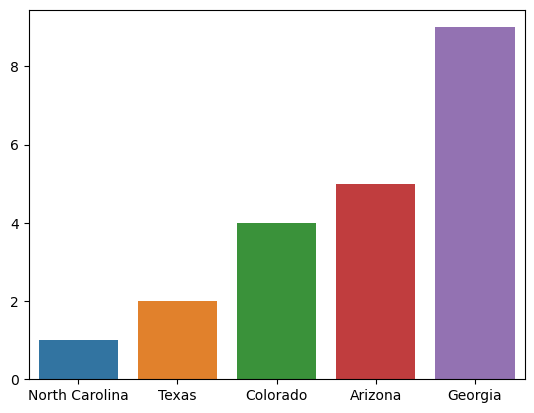

In [56]:
sns.barplot(data = st)

In [ ]:
train.risk_score

2707      0
4983    745
4959    687
4492    782
995     724
       ... 
987     564
2512    740
443     598
4028    737
4980    648
Name: risk_score, Length: 2799, dtype: int64

In [91]:
inc = [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
r2 = len(train[(train.rent >= 1000) & (train.rent < 1101) & (train.bad_resident == 1)]) / len(train[(train.rent >= 1000) & (train.rent < 1101)])
r3 = (len(train[(train.rent > 1100) & (train.rent < 1201) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1100) & (train.rent < 1201)]))
r4 = (len(train[(train.rent >1200) & (train.rent < 1301) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1200) & (train.rent < 1301)]))
r5 = (len(train[(train.rent >1300) & (train.rent < 1401) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1300) & (train.rent < 1401)]))
r6= (len(train[(train.rent >1400) & (train.rent < 1501) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1400) & (train.rent < 1501)]))
r7 = (len(train[(train.rent >1500) & (train.rent < 1601) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1500) & (train.rent < 1601)]))
r8 = (len(train[(train.rent >1600) & (train.rent < 1701) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1600) & (train.rent < 1701)]))
r9 = (len(train[(train.rent >1700) & (train.rent < 1801) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1700) & (train.rent < 1801)]))
r10 = (len(train[(train.rent >1800) & (train.rent < 1901) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1800) & (train.rent < 1901)]))
r11 = (len(train[(train.rent >1900) & (train.rent < 10000000) & (train.bad_resident == 1)]) / 
len(train[(train.rent >1900) & (train.rent < 1000000)]))

In [97]:
rs = pd.DataFrame(data = {'<1100': r2, '<1200': r3, '<1300': r4, '<1400': r5,
                         '<1500': r6, '<1600': r7, '<1700':r8, '<1800': r9,
                         '<1900': r10, '>1900': r11}, index = [0])

In [98]:
rs = rs.T.sort_values(0).T

In [99]:
rs = rs.round(2) * 100

<AxesSubplot:>

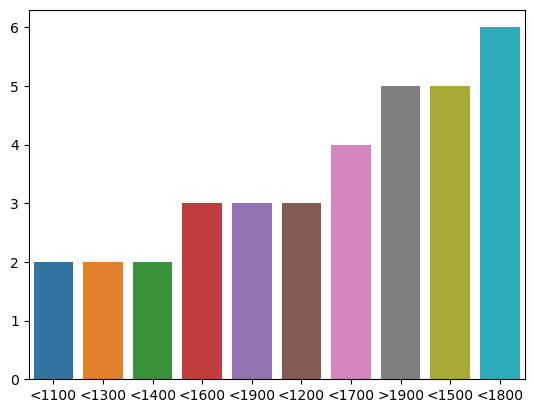

In [100]:
sns.barplot(data = rs)

In [104]:
[2,4,6,11,12,13,14,15,16,17,18]
t1 = len(train[(train.term == 2) & (train.bad_resident == 1)])/ len(train[train.term == 2])
t2 = len(train[(train.term == 4) & (train.bad_resident == 1)])/ len(train[train.term == 4])
t3 = len(train[(train.term == 6) & (train.bad_resident == 1)])/ len(train[train.term == 6])
t4 = len(train[(train.term == 11) & (train.bad_resident == 1)])/ len(train[train.term == 11])
t5 = len(train[(train.term == 12) & (train.bad_resident == 1)])/ len(train[train.term == 12])
t6 = len(train[(train.term == 13) & (train.bad_resident == 1)])/ len(train[train.term == 13])
t7 = len(train[(train.term == 14) & (train.bad_resident == 1)])/ len(train[train.term == 14])
t8 = len(train[(train.term == 15) & (train.bad_resident == 1)])/ len(train[train.term == 15])
t9 = len(train[(train.term == 16) & (train.bad_resident == 1)])/ len(train[train.term == 16])
t10 = len(train[(train.term == 17) & (train.bad_resident == 1)])/ len(train[train.term == 17])
t11 = len(train[(train.term == 18) & (train.bad_resident == 1)])/ len(train[train.term == 18])

In [105]:
ter = pd.DataFrame(data = {'1': t1, '4': t2, '6': t3, '11':t4, '12':t5, '13':t6, '14':t7, 
                           '15':t8, '16':t9, '17':t10, '18':t11}, index = [0])

In [106]:
ter = ter.T.sort_values(0).T

In [107]:
ter = ter.round(2) * 100

<AxesSubplot:>

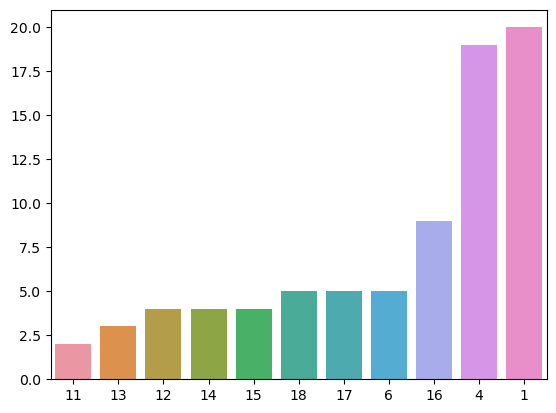

In [109]:
sns.barplot(data = ter)